In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score

from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc


In [3]:
file_path = '/Users/anhyebin/Documents/SKN21/SKN21-2nd-4Team/data/processed/Customer_Churn_Dataset_0_impute_onehot.csv'

df = pd.read_csv(file_path)

if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

target_col = "Churn_1"
X = df.drop(columns=[target_col], axis=1)
y = df[target_col]



In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# print(X.shape, y.shape)

In [7]:
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [8]:
model = LogisticRegression(solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [9]:
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)


print(f"F1-score: {f1:.5f}")
print(f"Recall: {recall:.5f}")
print(f"Accuracy: {acc:.5f}")

F1-score: 0.71724
Recall: 0.69519
Accuracy: 0.85451


In [10]:
# coef = model.coef_[0]
# for f, c in zip(X.columns, coef):
#     print(f"{f}: {c:.5f}")

In [11]:
# # 피처 이름과 계수 가져오기
# coef = model.coef_[0]
# features = X_train.columns
# coef_df = pd.DataFrame({'feature': features, 'coef': coef})

# # 절댓값 기준으로 정렬
# coef_df['abs_coef'] = coef_df['coef'].abs()
# coef_df = coef_df.sort_values(by='abs_coef', ascending=False)

# # 시각화
# plt.figure(figsize=(10,8))
# sns.barplot(x='coef', y='feature', data=coef_df)
# plt.title("Logistic Regression Feature Coefficients")
# plt.xlabel("Coefficient Value")
# plt.ylabel("Feature")
# plt.axvline(0, color='black', linestyle='--')
# plt.show()


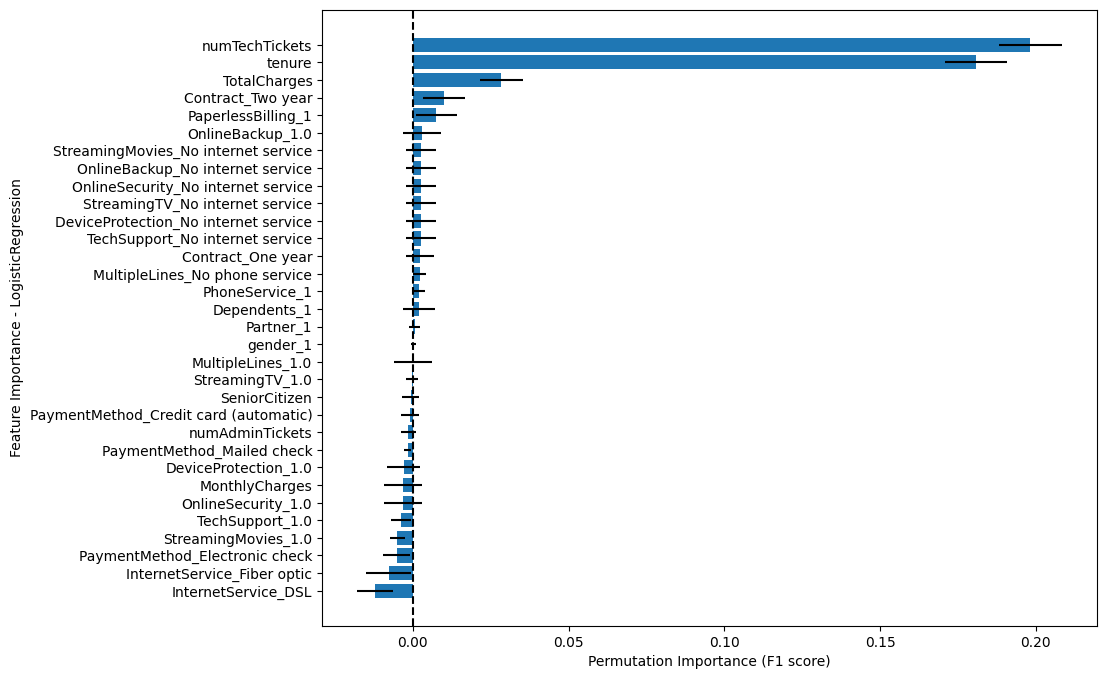

In [12]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='f1')

importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std':result.importances_std
})

importance_df = importance_df.sort_values(by='importance_mean', ascending=False)

plt.figure(figsize=(10,8))
plt.barh(importance_df['feature'], importance_df['importance_mean'], xerr=importance_df['importance_std'])
plt.gca().invert_yaxis()  #중요도 높은 순서
plt.xlabel("Permutation Importance (F1 score)")
plt.ylabel("Feature Importance - LogisticRegression")
plt.axvline(0, color='black', linestyle='--')
plt.show()

In [13]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [14]:
threshold = 0.01
important_features = importance_df[importance_df['importance_mean']>threshold]['feature'].tolist()

X_train_selected = X_train[important_features] 
X_test_selected = X_test[important_features] 

model2 = LogisticRegression(solver='liblinear', 
                            # class_weight='balanced', 
                            max_iter=1000 ) 


model2.fit(X_train_selected, y_train) 
y_pred2 = model2.predict(X_test_selected) 
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1035
           1       0.72      0.70      0.71       374

    accuracy                           0.85      1409
   macro avg       0.81      0.80      0.80      1409
weighted avg       0.85      0.85      0.85      1409



In [15]:
threshold = 0.01
important_features = importance_df[importance_df['importance_mean']>threshold]['feature'].tolist()


X_train_selected = X_train[important_features]
X_test_selected = X_test[important_features]


param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["liblinear", "lbfgs"],
    "max_iter": [500, 1000, 2000]

}

grid = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    scoring="f1",    
    cv=5,
    n_jobs=-1
)


model2 = LogisticRegression(solver='liblinear',
                            # class_weight='balanced',
                            max_iter=1000
                            )
model2.fit(X_train_selected, y_train)

y_pred2 = model2.predict(X_test_selected)
print(classification_report(y_test, y_pred2))


              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1035
           1       0.72      0.70      0.71       374

    accuracy                           0.85      1409
   macro avg       0.81      0.80      0.80      1409
weighted avg       0.85      0.85      0.85      1409



In [16]:
print(classification_report(y_test, y_pred2))

cm = confusion_matrix(y_test, y_pred2)
print(cm)

print("\n\nROC_AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1035
           1       0.72      0.70      0.71       374

    accuracy                           0.85      1409
   macro avg       0.81      0.80      0.80      1409
weighted avg       0.85      0.85      0.85      1409

[[933 102]
 [112 262]]


ROC_AUC: 0.9269420548192927


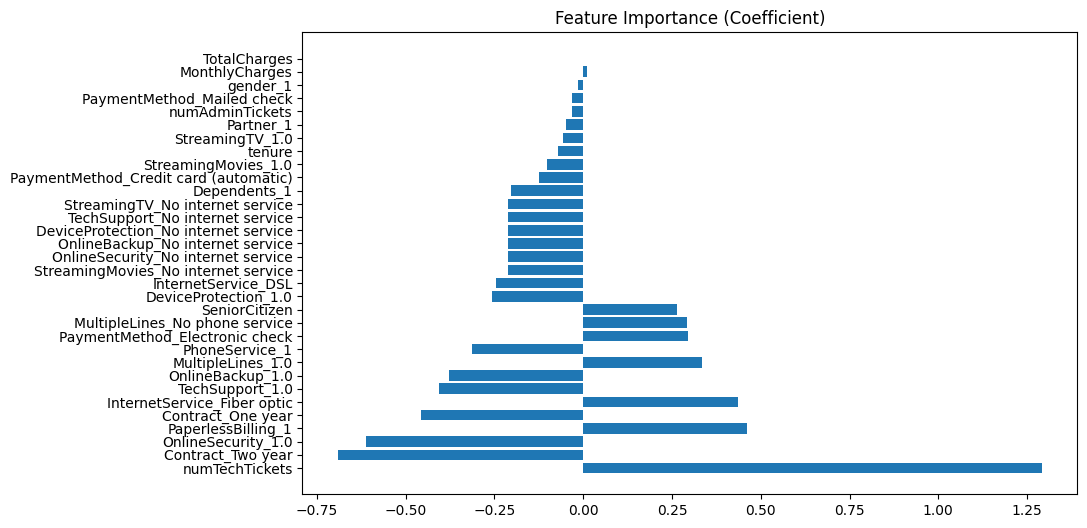

In [17]:
coef_df = pd.DataFrame({'feature': X_train.columns,
                        'coefficient': model.coef_[0]
}).sort_values(by='coefficient', key=abs, ascending=False)


plt.figure(figsize=(10,6))
plt.barh(coef_df['feature'], coef_df['coefficient'])
plt.title("Feature Importance (Coefficient)")
plt.show()


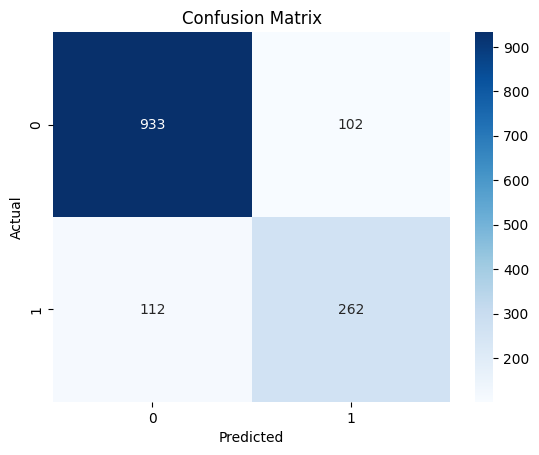

In [18]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

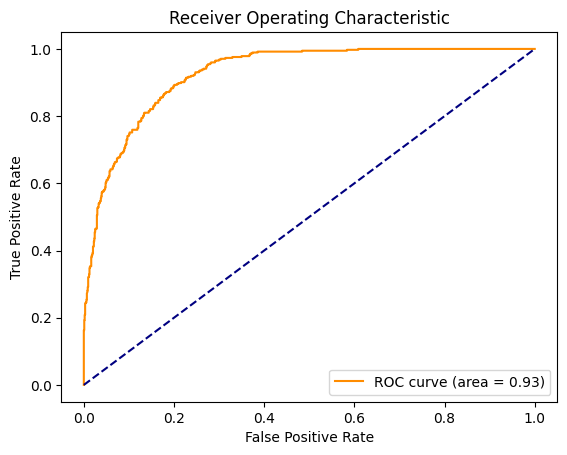

In [19]:
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [20]:
y_pred2 = model.predict(X_test)

f1 = f1_score(y_test, y_pred2)
recall = recall_score(y_test, y_pred2)
acc = accuracy_score(y_test, y_pred2)
pred = precision_score(y_test, y_pred2)

print(f"F1-score: {f1:.5f}")
print(f"Recall: {recall:.5f}")
print(f"Accuracy: {acc:.5f}")
print(f"Precision: {pred:.5f}")

F1-score: 0.71724
Recall: 0.69519
Accuracy: 0.85451
Precision: 0.74074


[I 2025-11-24 15:24:13,854] A new study created in memory with name: no-name-88b2ee20-159a-4455-8677-329aa6979532


/var/folders/yp/z5nzs43n4f33qt0kt_7r79lw0000gn/T/ipykernel_29533/1834806869.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 10)
/Users/anhyebin/Documents/SKN21/SKN21-2nd-4Team/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anhyebin/Documents/SKN21/SKN2

Best trial params: {'C': 0.5393988595259143, 'penalty': 'l1'}
Best trial ROC-AUC: 0.9202101755709735
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1036
           1       0.73      0.73      0.73       373

    accuracy                           0.86      1409
   macro avg       0.82      0.82      0.82      1409
weighted avg       0.86      0.86      0.86      1409



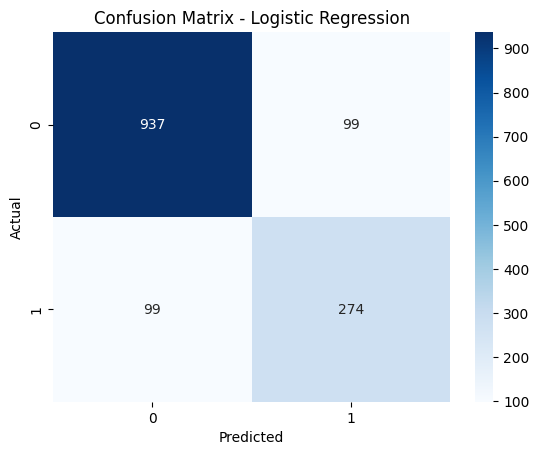

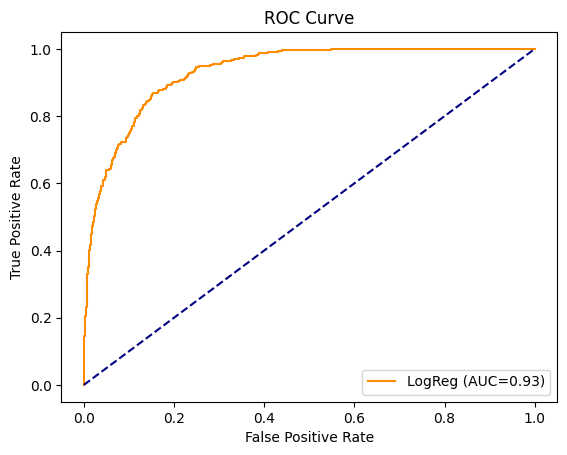

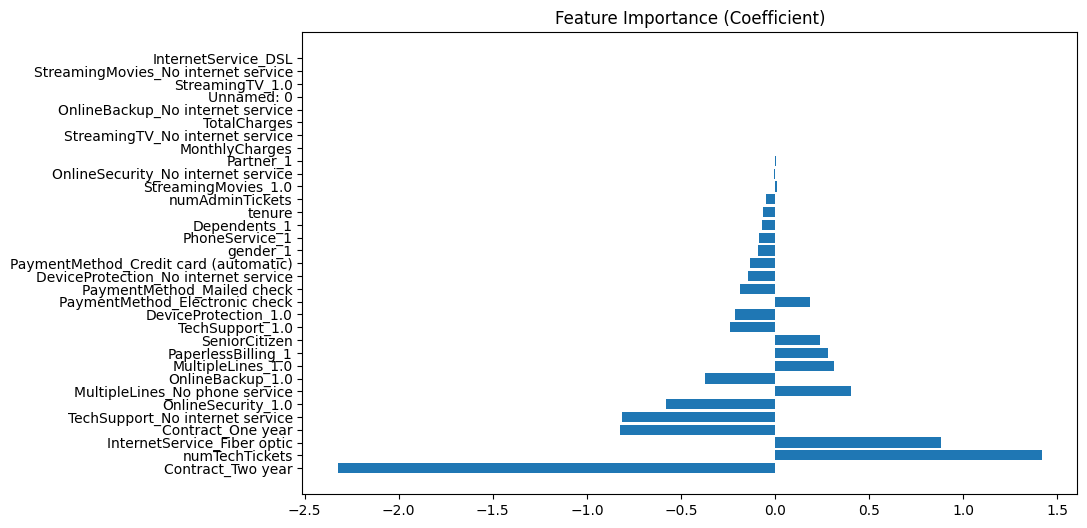

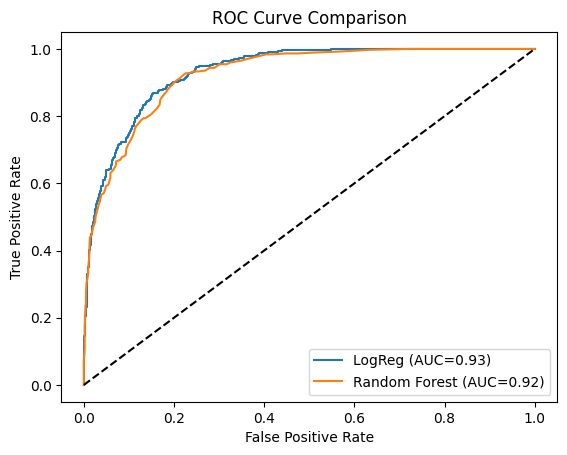

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [123]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import optuna
import optuna.visualization as vis


df = pd.read_csv('/Users/anhyebin/Documents/SKN21/SKN21-2nd-4Team/data/processed/Customer_Churn_Dataset_0_impute_onehot.csv')


X = df.drop(columns=['Churn_1'])
y = df['Churn_1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def objective(trial):
    # 하이퍼파라미터 탐색
    C = trial.suggest_loguniform('C', 1e-4, 10)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'

    model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=1000)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)


print("Best trial params:", study.best_trial.params)
print("Best trial ROC-AUC:", study.best_trial.value)

best_params = study.best_trial.params
solver = 'liblinear' if best_params['penalty']=='l1' else 'lbfgs'
model_lr = LogisticRegression(
    C=best_params['C'], penalty=best_params['penalty'], solver=solver, max_iter=1000
)
model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)
y_prob = model_lr.predict_proba(X_test)[:,1]


print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


#  ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'LogReg (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# Feature Importance (Coefficient)

coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': model_lr.coef_[0]
}).sort_values(by='coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
plt.barh(coef_df['feature'], coef_df['coefficient'])
plt.title("Feature Importance (Coefficient)")
plt.show()

#비교 

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_prob_rf = model_rf.predict_proba(X_test)[:,1]

# ROC-AUC 비교
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr, tpr, label=f'LogReg (AUC={roc_auc:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_rf:.2f})')
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


# vis.plot_optimization_history(study)
vis.plot_param_importances(study)


In [26]:
import os
import joblib
os.makedirs('../models/ML', exist_ok=True)

# 모델 저장
joblib.dump(model2, '../src/models/ML/LogisticRegression_model.pkl')

['../src/models/ML/LogisticRegression_model.pkl']